# Step 4 | Image Classification with CNN all 101 food classes

## Initial Setup

In [2]:
# mount drive
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True) # force remount to ensure new directories are included

Mounted at /content/gdrive


In [3]:
# check GPU is enabled
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
# unzip train data (test data already unzipped on drive)
#!unzip -q "/content/gdrive/MyDrive/Colab/data/train.zip" 

In [4]:
import seaborn as sns

import fastai.vision as fv
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from sklearn.manifold import TSNE
from sklearn import manifold, datasets
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import confusion_matrix
from scipy.spatial.distance import squareform
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.ticker import NullFormatter
import PIL


# ignore warning
import warnings
warnings.filterwarnings('ignore')

----

In the sections below we will replicate the code that was tested on three classes only to the whole Food-101 dataset. We will build the model using the **fastai library**.<br/>

For a more detailed explanation about the code and its theoretical underpinnings please refer to the notebook *03_ig_image_classification_mini.ipynb*. In fact, in this notebook we'll mostly focus on scaling the code to a larger dataset with a few concise code descriptions.

----

## Create dataloader

As its effectiveness was proven in the prototype, to scale up our model to the full dataset we will adopt the technique of **Image Augmentation**. The parameter ```tfms```, defined below, will set the main transformations of our Composite Image Augmentation pipeline. <br/>

In particular, we will implement the following augmentations:
* dihedral affine transformation (```do_flip``` and ```flip_vert```)
* simmetric warp (```max_warp```)
* rotation (```max rotate```)
* zoom (```max_zoom```)
* brightness (```max_lighting```)

In [5]:
# define paths
path_meta = "/content/gdrive/MyDrive/Colab/data/meta/"
path_test = "/content/gdrive/MyDrive/Colab/data/test"
path_train = "/content/gdrive/MyDrive/Colab/data/train"

In [7]:
# batch size
bs = 25

In [8]:
# image augmentation transform functions
tfms = get_transforms(do_flip=True, 
                      flip_vert=True, 
                      max_rotate=10.0,
                      max_zoom = 1.1,
                      max_lighting=0.25,
                      max_warp=0.25)

In [9]:
# create dataloader
data = (ImageList.from_folder(path_train).split_by_rand_pct(0.1, seed=42) # validation set = 10%
                                       .label_from_folder(classes=None) 
                                       .transform(tfms=tfms, size=256)
                                       .databunch(bs=bs, num_workers=6))

In [10]:
data

ImageDataBunch;

Train: LabelList (68171 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
cheese_plate,cheese_plate,cheese_plate,cheese_plate,cheese_plate
Path: /content/gdrive/MyDrive/Colab/data/train;

Valid: LabelList (7574 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
cheese_plate,gyoza,creme_brulee,shrimp_and_grits,huevos_rancheros
Path: /content/gdrive/MyDrive/Colab/data/train;

Test: None

## CNN Model Training

We will start training the model with a **<mark>pre-trained Resnet-50 model<mark/>**, which presents 48 Convolution layers along with 1 MaxPool and 1 Average Pool layer. To transfer the pre-trained model to the Food-101 dataset we will add a few linear layers at the end of the model. 

The model will then be trained in two phases:
1. **Training Phase 1**: freeze pre-trained weights of the ResNet50 model and only train the few untrained and naive layers we added at the end of the CNN. The objective here is to train the last few linear layers in such a way that they perform decently well before we retrain the whole model.
2. **Training Phase 2**: unfreeze the entire model and train with discriminative learning rates. We will train the initial layers at the lower learning rate than the last layers. This is due to the fact that initial layers learn relatively simple components of an image (e.g. edge, shapes, curves) while later layers learn finer aspects of an image. The initial layers, being part of the pre-trained ResNet50 model, are already well-tuned and don't need to be aggressively retrained. Differently, the later layers (especially the ones that we added to the model) need a heavier training to learn the subtleties of our Food-101 dataset.

Regarding the alternation of learning rates, we will follow the **<mark>One Cycle Learning Rate<mark/>** approach (introduced by Leslie Smith in this paper). In line with this approach, the learning rate will start small and then progressively increase up to a peak, when it will start decreasing again.<br/>

Finally, in addition to the composite image augmentation technique, we will also use **<mark>mixup augmentation<mark/>**. As presented in [this paper](https://arxiv.org/pdf/1710.09412.pdf), this technique implies linearly interpolating between two images to create a new augmented image. Then, it computes the new target accordingly. See the representative formulas below.<br/>

$\ image_n = t * image_1 + (1-t) * image_2 $<br/>
$\ target_n = t * target_1 + (1-t) * target_2 $

where $\ image_n $ and $\ target_n $ are respectively the new image and the new target, and $\ t$ is a value between 0 and 1.<br/>

### 1. Training Phase 1 | freeze ResNet50 layers and train new layers

In [11]:
# create learner object from fast.ai library
# learner is a container of the data, the model, the optimizer and other parameters for training
learn = cnn_learner(data, 
                    models.resnet50, 
                    metrics=error_rate,
                    ps=0.4, 
                    wd=5e-3)

# implement mixup augmentation
learn = learn.mixup()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


In [12]:
# check weight decay
learn.wd

0.005

In [13]:
# check model linear head
learn.model[1]

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten()
  (2): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.2, inplace=False)
  (4): Linear(in_features=4096, out_features=512, bias=True)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.4, inplace=False)
  (8): Linear(in_features=512, out_features=101, bias=True)
)

In [14]:
# visualize model
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

In [15]:
# check loss function
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [ ]:
# lower required memory needed for training with fp16
learn = learn.to_fp16(dynamic=True);
learn.freeze()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.45E-03
Min loss divided by 10: 1.32E-03


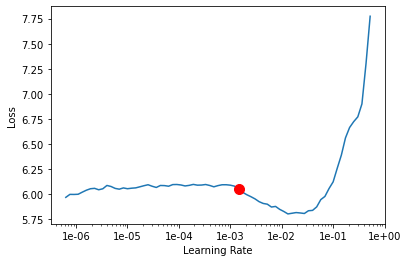

In [ ]:
# visualize loss by learning rate to find the optimal lr to pass in model training
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
# define optimal lr for initial model training
min_grad_lr = learn.recorder.min_grad_lr
min_grad_lr

0.001445439770745928

----
**ONE CYCLE POLICY & DISCRIMINATIVE LEARNING**

The **<mark>fit_one_cycle()<mark/>** method, resulting from Leslie Smith's research on one cycle policy, is known to have better performance in speed and accuracy over the fit() method. According to this methodology, the learning rate is small at first and then progressively increases, to decrease again after a peak. <br/>
As mentioned in the [fast.ai video](https://course.fast.ai/videos/?lesson=6), after having frozen the pre-trained model layers it's common to include a first ```slice(stop = lr_stop)``` in the ```fit_one_cycle()``` method. This way, the last parameter group will use a learning rate of ```lr_stop```, while the other groups will have ```lr_stop/10```. By running the ```lr_find()``` with ```suggestion=True``` we can identify the point on the loss curve with the steepest gradient.
    
Once the learner has been unfrozen, we need to reapply the ```fit_one_cycle()```, but this time we will mention both *start* and *stop* parameters in the slice for *max_lr*. So, we will end up with a syntax like ```max_lr = slice(start = lr_start, stop = lr_stop, step = None)```. This means that the first layer will be trained with ```lr_start``` learning rate, the last layer will be trained with ```lr_stop``` learning rate and the layers in between will be equally spaced. Now, to find ```lr_start``` and ```lr_stop``` we need to rerun the ```lr_find()``` and, looking at the curve, we should identify the point after which the loss starts increasing again and set this as the end point of a range of around one unit. It's important to note that this last method is fairly empirical and there is not much documentation yet on how to best set this slice parameter.     
    
----   

In [ ]:
# train linear head
learn.fit_one_cycle(8, max_lr=slice(min_grad_lr)) # 8 epochs and max_lr = slice(start = None, stop = min_grad_lr, step = None)

epoch,train_loss,valid_loss,error_rate,time
0,3.286917,1.974129,0.498284,56:54
1,2.856862,1.609390,0.411407,10:53
2,2.607733,1.428152,0.361236,10:55
3,2.514732,1.303983,0.336942,11:00
4,2.422556,1.231960,0.310404,11:03
5,2.318898,1.172863,0.296805,11:03
6,2.287624,1.142349,0.291392,10:59
7,2.328211,1.132699,0.291656,10:56


> As we notice, the losses and error rate decrease from epoch 0 to epoch 6, when the error rate starts stagnating while the losses keep decreasing until the last epoch 7.

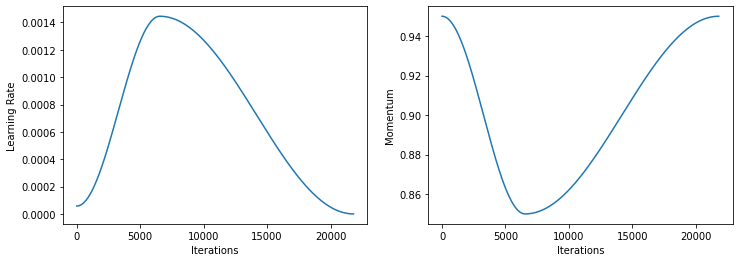

In [ ]:
# show learning rate and momentum for different iterations
learn.recorder.plot_lr(show_moms=True)

> In the plot above we note how, in alignment with the one cycle learning approach, the learning rate and momentum follow opposite patterns from the initial to the last layer of the CNN.

In [ ]:
# save model
learn.save('food_mix_full_ds_1') 

### 2. Training Phase 2 | unfreeze ResNet50 layers and train the whole model

In this section, we will start by unfreezing the model. Then, we will plot the loss against learning rate to identify the optimal learning rate range to pass in the final training of the model.<br/>

As mentioned above, the end point of the optimal learning rate range is the learning rate coordinate of the point of the loss curve right before the curve starts picking up in slope again. The starting point of the range is 10 units from the end point towards the origin.

In [ ]:
# unfreeze model
learn.unfreeze()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


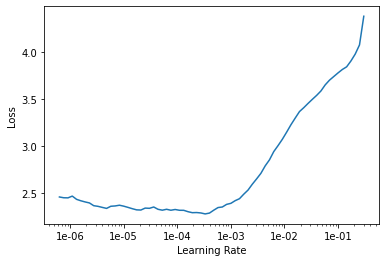

In [ ]:
# rerun the method to find optimal lr
learn.lr_find()
learn.recorder.plot()

> In line with the logic explained above, the optimal learning rate range is ```(start=3e-5,stop=3e-4, step=None)```.

In [ ]:
# train entire model with discriminative learning rates & one cycle policy 
# discriminative learning rates - small learning rate for earlier layers and large learning rate for later layers
learn.fit_one_cycle(12, max_lr=slice(3e-5,3e-4)) # 12 epochs and max_lr = slice(start = 3e-5, stop = 3e-4, step = None)

epoch,train_loss,valid_loss,error_rate,time
0,2.276145,1.080977,0.278057,11:52
1,2.222874,1.078325,0.278981,11:55
2,2.234282,1.075932,0.280037,11:52
3,2.204054,1.015490,0.260893,11:42
4,2.069284,0.961266,0.247425,11:37
5,1.977999,0.895834,0.229865,11:42
6,1.955088,0.821663,0.206100,11:37
7,1.952048,0.780001,0.200026,11:28
8,1.793061,0.739932,0.188936,11:37
9,1.716824,0.720122,0.184183,11:52


In [ ]:
# save model
learn.save('food_mix_full_ds_2') 

In [16]:
# load model
learn.load('/content/gdrive/MyDrive/Colab/data/train/models/food_mix_full_ds_2'); 

In [17]:
# interpret classification output
model_interp = ClassificationInterpretation.from_learner(learn.to_fp32())
losses,idxs = model_interp.top_losses()

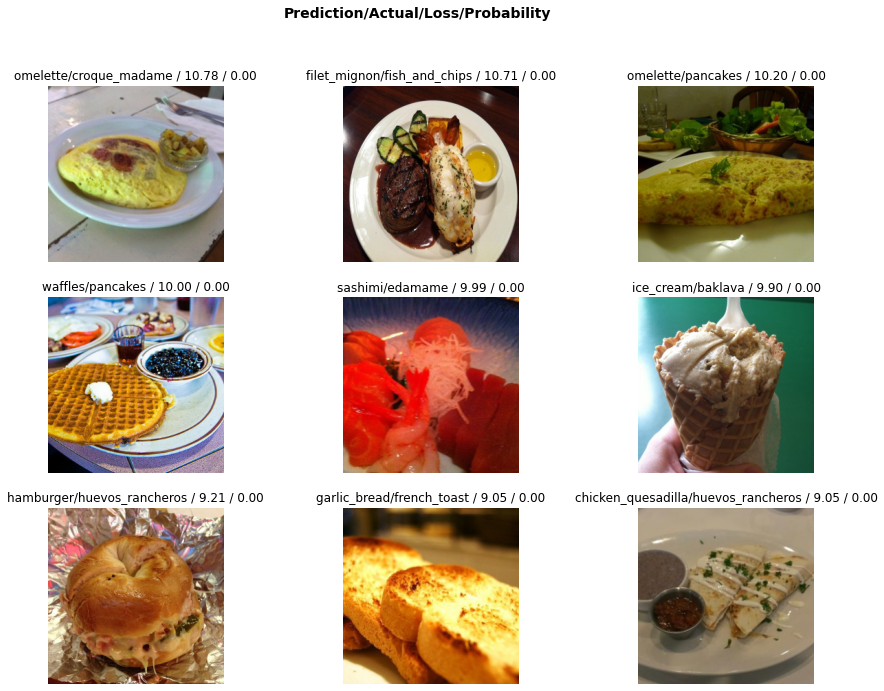

In [18]:
# identify most misclassified classes
model_interp.plot_top_losses(9, figsize=(15,11), heatmap=False)

In [19]:
# identify most confused classes
model_interp.most_confused(min_val=4)

[('steak', 'filet_mignon', 11),
 ('chocolate_mousse', 'chocolate_cake', 10),
 ('cheesecake', 'strawberry_shortcake', 9),
 ('dumplings', 'gyoza', 9),
 ('onion_rings', 'fried_calamari', 8),
 ('prime_rib', 'filet_mignon', 8),
 ('tiramisu', 'chocolate_mousse', 8),
 ('chocolate_cake', 'chocolate_mousse', 7),
 ('filet_mignon', 'steak', 7),
 ('scallops', 'shrimp_and_grits', 7),
 ('apple_pie', 'bread_pudding', 6),
 ('apple_pie', 'cheesecake', 6),
 ('beignets', 'donuts', 6),
 ('bread_pudding', 'apple_pie', 6),
 ('ceviche', 'tuna_tartare', 6),
 ('chocolate_cake', 'tiramisu', 6),
 ('chocolate_mousse', 'panna_cotta', 6),
 ('pork_chop', 'filet_mignon', 6),
 ('pork_chop', 'scallops', 6),
 ('sushi', 'sashimi', 6),
 ('chicken_quesadilla', 'breakfast_burrito', 5),
 ('falafel', 'crab_cakes', 5),
 ('lobster_bisque', 'clam_chowder', 5),
 ('steak', 'pork_chop', 5),
 ('baby_back_ribs', 'steak', 4),
 ('beef_carpaccio', 'tuna_tartare', 4),
 ('cheesecake', 'panna_cotta', 4),
 ('chocolate_mousse', 'ice_cream', 

### 3. Prediction on Test set

**Test Time Augmentation (TTA)** is an application of data augmentation to the test dataset. In particular, it involves randomly creating multiple augmented copies of each image in the test set, having the model make a prediction for each, then returning an ensemble of those predictions. <br/>

We will run two sets of predictions, one with and one without TTA.

### Predictions without TTA

In [21]:
# define path to images
path_images = "/content/gdrive/MyDrive/Colab/data/"

In [22]:
# create dataloader from test data
data_test = (ImageList.from_folder(path_images).split_by_folder(train='train', valid='test')
                                       .label_from_folder(classes=None)
                                       .transform(tfms=tfms, size=216)
                                       .databunch(bs=bs, num_workers=8))

In [23]:
learn.data = data_test

In [24]:
learn.data

ImageDataBunch;

Train: LabelList (75745 items)
x: ImageList
Image (3, 216, 216),Image (3, 216, 216),Image (3, 216, 216),Image (3, 216, 216),Image (3, 216, 216)
y: CategoryList
cheese_plate,cheese_plate,cheese_plate,cheese_plate,cheese_plate
Path: /content/gdrive/MyDrive/Colab/data;

Valid: LabelList (25250 items)
x: ImageList
Image (3, 216, 216),Image (3, 216, 216),Image (3, 216, 216),Image (3, 216, 216),Image (3, 216, 216)
y: CategoryList
foie_gras,foie_gras,foie_gras,foie_gras,foie_gras
Path: /content/gdrive/MyDrive/Colab/data;

Test: None

In [25]:
learn = learn.to_fp32()

In [26]:
# compute predictions
preds, y = learn.get_preds()

In [27]:
# compute top-1 accuracy
accuracy(preds, y)

tensor(0.8503)

In [28]:
# compute top-5 accuracy
top_k_accuracy(preds, y, k=5)

tensor(0.9694)

### Predictions with TTA

Conducting predictions with TTA will imply performing **9 predictions**. One set of predictions will be on the non-augmented test set. Then, the other 8 predictions will be on augmented versions of the test set images. The final prediction will be the linear interpolation between the non-augmented prediction and the average of the augmented predictions. <br/>

In order to control the interpolation, the parameter ```beta``` will be used. For instance, ```beta = 0.4```, the model will take 40% of the unaugmented prediction and 60% of the average of the augmented predictions.

In [29]:
preds_tta, y_tta = learn.TTA(beta=0.4, scale=1.05) # scale parameter controls scale for zoom (not random)

In [30]:
# top-1 accuracy
accuracy(preds_tta, y_tta)

tensor(0.8636)

In [31]:
# top-5 accuracy
top_k_accuracy(preds_tta, y_tta, k=5)

tensor(0.9738)

## Interpreting predictions and model performance

Even if we are quite satisfied with our top-1 accuracy, we should go deeper and understand how the model is truly performing.

In [32]:
# rerun interpretations
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

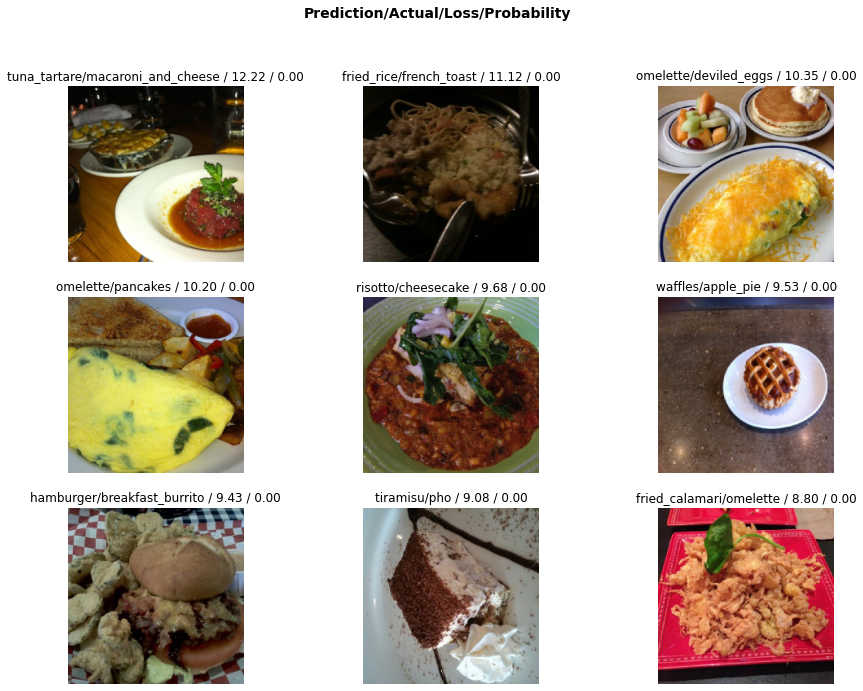

In [33]:
# plot images
interp.plot_top_losses(9, figsize=(15,11), heatmap=False)

In [34]:
# identify most confused classes
interp.most_confused(min_val=9)

[('steak', 'filet_mignon', 50),
 ('pork_chop', 'filet_mignon', 23),
 ('chocolate_mousse', 'chocolate_cake', 22),
 ('tuna_tartare', 'beef_tartare', 22),
 ('filet_mignon', 'steak', 21),
 ('cheesecake', 'strawberry_shortcake', 19),
 ('chocolate_cake', 'chocolate_mousse', 19),
 ('pork_chop', 'grilled_salmon', 19),
 ('prime_rib', 'steak', 18),
 ('apple_pie', 'bread_pudding', 17),
 ('beef_tartare', 'tuna_tartare', 17),
 ('sashimi', 'sushi', 17),
 ('pork_chop', 'steak', 16),
 ('chocolate_cake', 'tiramisu', 15),
 ('donuts', 'cup_cakes', 15),
 ('ice_cream', 'frozen_yogurt', 15),
 ('club_sandwich', 'grilled_cheese_sandwich', 14),
 ('steak', 'pork_chop', 14),
 ('steak', 'prime_rib', 14),
 ('crab_cakes', 'falafel', 13),
 ('dumplings', 'gyoza', 13),
 ('poutine', 'french_fries', 13),
 ('ravioli', 'gnocchi', 13),
 ('breakfast_burrito', 'huevos_rancheros', 12),
 ('clam_chowder', 'lobster_bisque', 12),
 ('foie_gras', 'beet_salad', 12),
 ('gyoza', 'dumplings', 12),
 ('huevos_rancheros', 'tacos', 12),
 (

## TSNE Visualizations

Let's now use TSNE to see how predictions cluster in space. We will run TSNE on the prediction vectors from the TTA prediction; hence, softmax will already be applied. Softmax transforms a vector's values into values between 0 and 1, so that they can be interpreted as probabilities. <br/>

In our specific case, the impact of softmax is to make predictions to have one value that is close to 1, which has a good effect on clustering of classes.  

### 1. TSNE on all food classes

In [35]:
# apply tsne to tta predictions
probs_trans = manifold.TSNE(n_components=2, perplexity=15).fit_transform(preds_tta)

In [36]:
# create df
prob_df = pd.DataFrame(np.concatenate((probs_trans, y_tta[:,None]), axis=1), columns=['t-SNE dimension 1','t-SNE dimension 2','labels'])

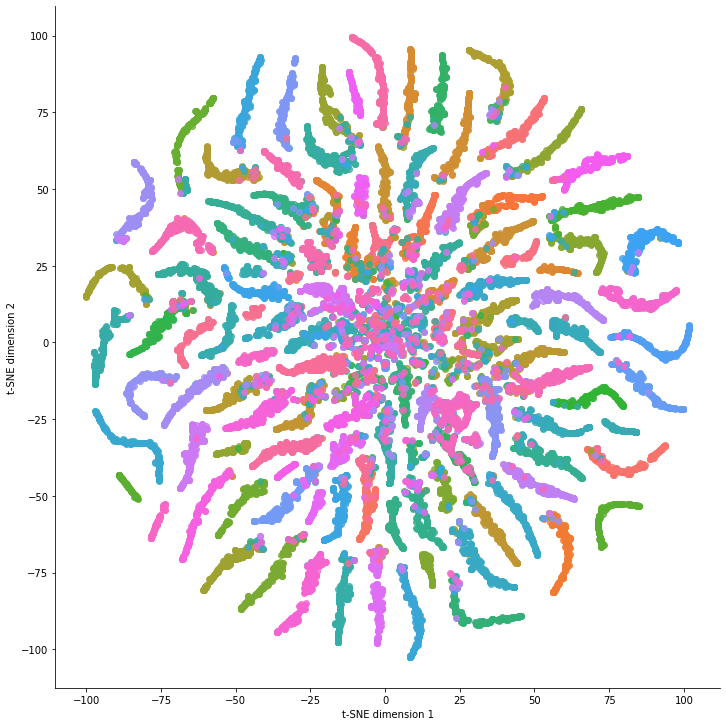

In [37]:
# plot tsne without legend because of large amount of classes
g = sns.lmplot('t-SNE dimension 1', 't-SNE dimension 2', data=prob_df, hue='labels', fit_reg=False, legend=False, height=10, seed=42)

Here we see all the 25250 predictions from the test set split across rather separable clusters.

### 2. TSNE on commonly confused food classes

Let's now visualize a t-SNE plot for classes that are commonly confused with each other. Labels are based on the true image class.

In [38]:
# rebuild TSNE based on frequently confused classes
food_classes_confused = ['steak', 'filet_mignon', 'prime_rib', 'pork_chop']

codes_c = [data_test.classes.index(i) for i in food_classes_confused]

preds_c = [preds_tta[y_tta==i] for i in codes_c]
ys_c = [y_tta[y_tta==i] for i in codes_c]

preds_stack_c = torch.cat(preds_c, dim=0)
ys_stack_c = torch.cat(ys_c, dim=0)

In [39]:
tsne_c = manifold.TSNE(n_components=2, perplexity=15).fit_transform(preds_stack_c)

In [40]:
df_c = pd.DataFrame(np.concatenate((tsne_c, ys_stack_c[:,None]), axis=1), columns=['t-SNE dimension 1','t-SNE dimension 2','labels'])

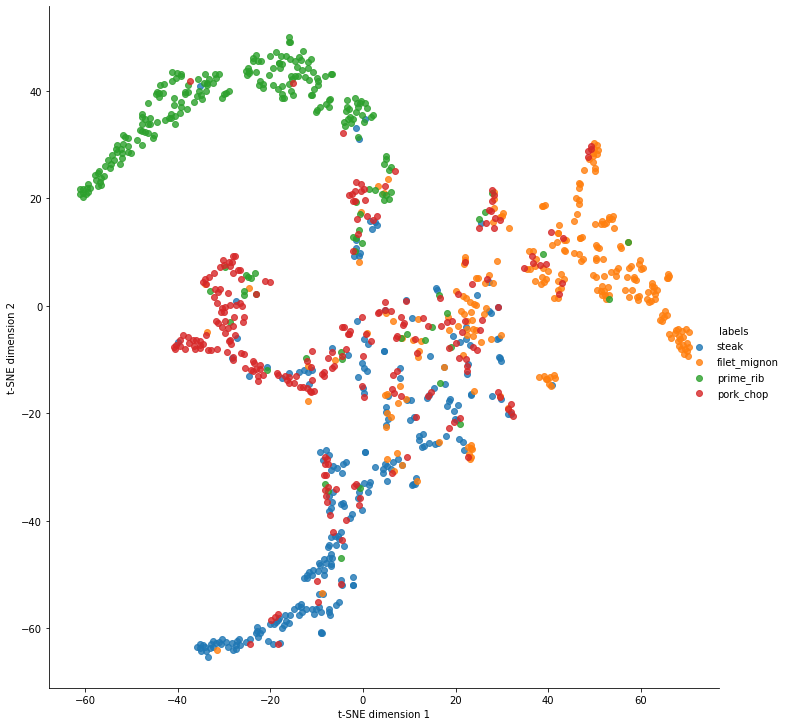

In [41]:
# plot tsne
h = sns.lmplot('t-SNE dimension 1', 't-SNE dimension 2', data=df_c, hue='labels', fit_reg=False, legend=True, height=10)

# rename legenda labels
for t, l in zip(h._legend.texts, food_classes_confused): 
  t.set_text(l)

As expected, there is not much separability amongst the classes and the observations tend to mix up across classes. 

### 3. TSNE on dissimilar food classes

Now let's look at a different case where classes are generally not confused with each other. Labels are based on the true image class.

In [42]:
# rebuild TSNE based on classes that are generally not confused with each other
food_classes_not_confused = ['cup_cakes', 'creme_brulee','fried_rice','caesar_salad','lasagna']

codes_nc = [data_test.classes.index(i) for i in food_classes_not_confused]

preds_nc = [preds_tta[y_tta==i] for i in codes_nc]
ys_nc = [y_tta[y_tta==i] for i in codes_nc]

preds_stack_nc = torch.cat(preds_nc, dim=0)
ys_stack_nc = torch.cat(ys_nc, dim=0)

In [43]:
tsne_nc = manifold.TSNE(n_components=2, perplexity=10).fit_transform(preds_stack_nc)

In [44]:
df_nc = pd.DataFrame(np.concatenate((tsne_nc, ys_stack_nc[:,None]), axis=1), columns=['t-SNE dimension 1','t-SNE dimension 2','labels'])

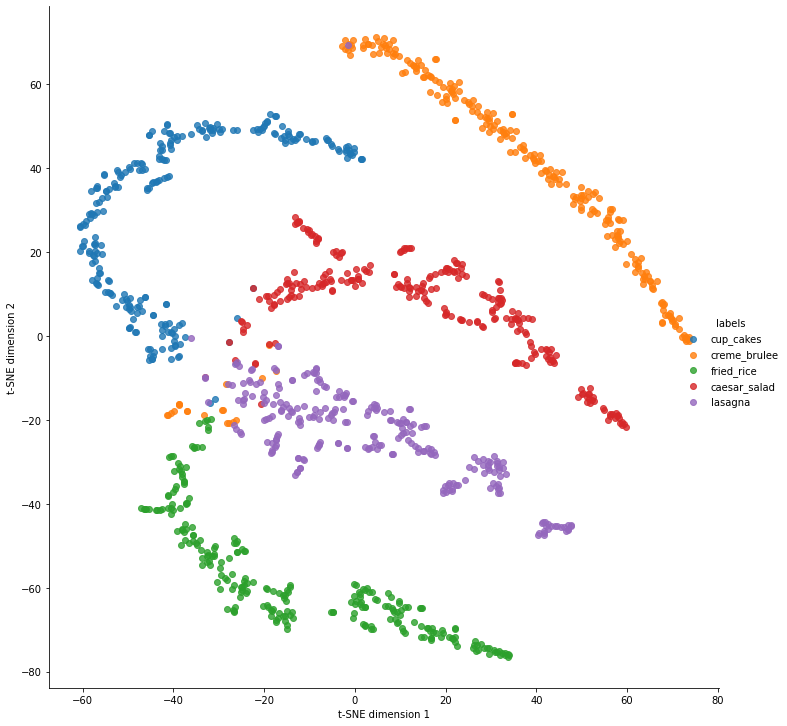

In [45]:
w = sns.lmplot('t-SNE dimension 1', 't-SNE dimension 2', data=df_nc, hue='labels', fit_reg=False, legend=True, height=10)

for t, l in zip(w._legend.texts, food_classes_not_confused): 
  t.set_text(l)

Here we see classes that are quite separable with very low blurring across classes.

----

We conclude this section with a **top-1 accuracy of 86.3%** and a **top-5 accuracy of 97.4%**.

----